In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt

### Target:
understand what we have in these datasets
1. meaning of the dataset fields
2. data issue

### Content:
1. Russell 3000
2. pricing_and_volumes
3. earnings
4. barra factos

### Results:
1. No duplicates in all the datasets
2. r3k_sec_mapping_df, pricing_and_volumes and earning_df have missing values:<br>
    2.1 r3k_sec_mapping_df: [barrid, barra_name, fsym_id]<br>
    2.2. pricing_and_volumes: [adj_volume] <br>
    2.3. earning_df: [announce_datetime]
3. In earning_df, assume the market already knows the info on effective date. So, effective_date will be utilized for feature engineering.
4. barra_factor_exposures_df:<br>
factor_group = '5-Market': ignore <br>
factor_group = '2-Industries': each barrid is classified into at least one industry<br>
factor_group = '1-Risk Indices': each barrid has a value for each factor in this group; ignore EFMUSATRD_CARBONEFF

In [2]:
### Preparation:
# 1. read data file names
folder_path = "F:/volume_prediction"
filenames = os.listdir(folder_path)
filenames = [x for x in filenames if x.endswith(".parquet")]

filenames

['barra_factor_exposures.parquet',
 'earnings.parquet',
 'pricing_and_volumes.parquet',
 'r3k_sec_mapping.parquet']

In [3]:
# 2. load data
import sys
sys.path.append("..")

from src.model_training_utils import read_data
# using pyarrow.parquet.read_table to load data
# columns and filters are useful to save memory

In [4]:
# russell 3000
r3k_sec_mapping_df = read_data("r3k_sec_mapping", folder_path=folder_path)
# pricing and volumes
pricing_and_volumes_df = read_data("pricing_and_volumes", folder_path=folder_path)
# earnings
earnings_df = read_data("earnings", folder_path=folder_path)
# barra_factor_exposures
barra_factor_exposures_df = read_data("barra_factor_exposures", folder_path=folder_path)

In [5]:
# 2. the time range of the mapping table
# the actual time range should be within the range
r3k_sec_mapping_df.date.min(), r3k_sec_mapping_df.date.max()

(datetime.date(2019, 1, 2), datetime.date(2023, 12, 29))

### 1. Russell 3000

In [6]:
# (1). Dataset info: columns and data type
# columns: ['date', 'barrid', 'cusip', 'isin', 'symbol', 'ticker', 
#           'constituent_name', 'barra_name', 'fsym_id', 'wt_r3']
r3k_sec_mapping_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3768759 entries, 0 to 3769749
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   barrid            object 
 2   cusip             object 
 3   isin              object 
 4   symbol            object 
 5   ticker            object 
 6   constituent_name  object 
 7   barra_name        object 
 8   fsym_id           object 
 9   wt_r3             float32
dtypes: float32(1), object(9)
memory usage: 301.9+ MB


In [7]:
# (2). Missing values: 'barrid', 'barra_name', 'fsym_id' have missing values
missing_test = r3k_sec_mapping_df.isna().any()
missing_test[missing_test]

barrid        True
barra_name    True
fsym_id       True
dtype: bool

In [8]:
# (3). Duplicate values: no duplicates in all the columns
r3k_sec_mapping_df.duplicated().any()

False

In [9]:
# (4). Weight
# (4.1). Weight should be positive: all tickers have positive weights
(r3k_sec_mapping_df.wt_r3>0).all()

True

In [10]:
# (4.2). Sum of the weights each day should be 1
weight_sum = r3k_sec_mapping_df.groupby("date")["wt_r3"].sum().round(2)
weight_sum[weight_sum !=1]

Series([], Name: wt_r3, dtype: float32)

min date, max date:  (datetime.date(2019, 1, 2), datetime.date(2023, 12, 29))


<Axes: xlabel='date'>

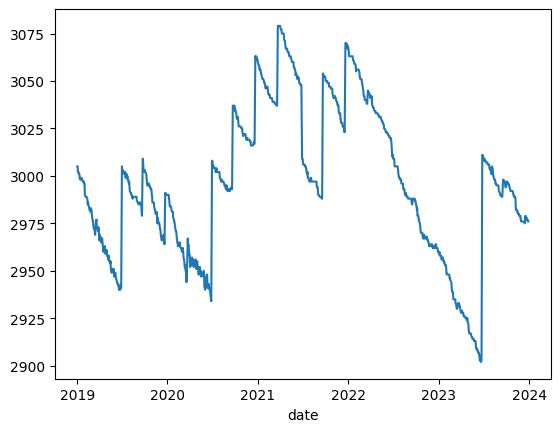

In [11]:
# (5). min and max date; the number of tickers each day
# (5.1). Time range: min and max dates
dates_list = r3k_sec_mapping_df.date.unique()
print("min date, max date: ", (min(dates_list), max(dates_list)))

# (5.2). Number of tickers each day
# Since there are no duplicate values, the number of tickers is accurate.
######>>>>>>Drop and sruge:
r3k_sec_mapping_df.groupby("date")["isin"].count().plot()

### 2. pricing_and_volumes
barra_factor_exposures.parquet is from Barra and is unique on `date`,
`barrid`,`factor`. For more details on factor definitions see included
"MSCI USA Equity Factor Trading Model (EFMUSATR) Empirical Notes.pdf".

In [12]:
# (1). Dataset info: columns and data type
pricing_and_volumes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4696107 entries, 0 to 5477424
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   barrid        object 
 1   date          object 
 2   unadj_price   float32
 3   adj_price     float32
 4   unadj_volume  int32  
 5   adj_volume    float32
 6   mkt_cap       float32
 7   is_adj_date   bool   
dtypes: bool(1), float32(4), int32(1), object(2)
memory usage: 201.5+ MB


In [13]:
# (2). Missing values: 'adj_volume' has missing values
missing_test = pricing_and_volumes_df.isna().any()
missing_test[missing_test]

adj_volume    True
dtype: bool

In [14]:
# (3). Duplicate values: no duplicates in all columns
pricing_and_volumes_df.duplicated().any()

False

min date, max date:  (datetime.date(2019, 1, 2), datetime.date(2023, 12, 29))


<Axes: xlabel='date'>

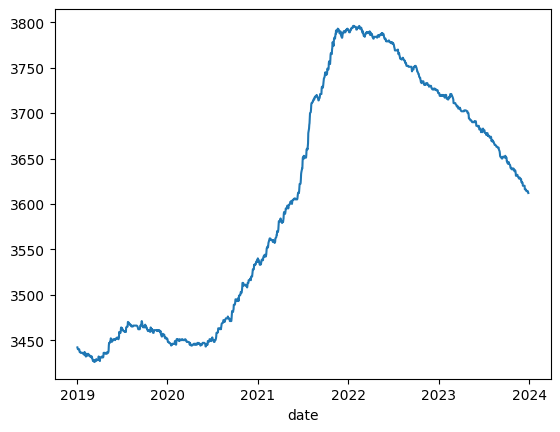

In [15]:
# (4). min and max date; the number of tickers each day
# (4.1). Time range: min and max dates
dates_list_pv = pricing_and_volumes_df.date.unique()
print("min date, max date: ", (min(dates_list_pv), max(dates_list_pv)))

# (4.2). Number of tickers each day
# Since there are no duplicate values, the number of tickers is accurate.
pricing_and_volumes_df.groupby("date")["barrid"].count().plot()

### 3. earnings
earnings.parquet is from Factset and is unique on `fiscal_period_end_date`,
`fsym_id`. `effective_date` is the first trading day partially or wholly
after the announcement of the earnings (i.e. if an announcement occurs post-
market, `effective_date` would be the next trading day). `announce_datetime`
is local date and time of the announcement in New York.

In [16]:
# (1). Dataset info: columns and data type
earnings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78614 entries, 0 to 95296
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fsym_id                 78614 non-null  object        
 1   fiscal_period_end_date  78614 non-null  object        
 2   effective_date          78614 non-null  object        
 3   announce_datetime       68795 non-null  datetime64[us]
dtypes: datetime64[us](1), object(3)
memory usage: 3.0+ MB


In [17]:
# (2). Missing values: 'announce_datetime' has missing values
missing_test = earnings_df.isna().any()
missing_test[missing_test]

announce_datetime    True
dtype: bool

In [18]:
# (3). Duplicate values: no duplicates
earnings_df.duplicated().any()

False

min date, max date:  (datetime.date(2019, 1, 2), datetime.date(2023, 12, 29))


<Axes: xlabel='fiscal_period_end_date'>

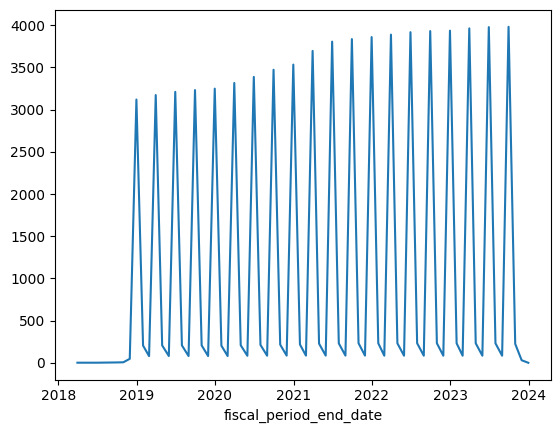

In [19]:
# (4). min and max date; the number of tickers each day
# (4.1). Time range: min and max dates
dates_list_earn = earnings_df.effective_date.unique()
print("min date, max date: ", (min(dates_list_earn), max(dates_list_earn)))

# (4.2). Number of fsym_ids each fiscal_period_end_date
# Since there are no duplicate values, the number of tickers is accurate.
earnings_df.groupby("fiscal_period_end_date")["fsym_id"].count().plot()

In [ ]:
# (5). effective_date >= announce_datetime based on field defination
# Note: `effective_date` is the first trading day partially or wholly after the announcement of the earnings
# >> Result: in some cases, announce_datetime is wrong, such as announce_datetime is in 2022 for 2018 fiscal year.
# In other cases, announce_datetime is 1~2 days after the effective date. 
# So, I use effective date here, skipping verifying dates due to limited time.

#--------------------------
# Deal with nan values of announce_datetime
earnings_df.loc[:, "announce_date2"] = np.where(earnings_df["announce_datetime"].isna(), earnings_df["effective_date"],
                                                earnings_df["announce_datetime"].dt.date)
# Test if effective_date >= announce_datetime
# Assumptions (need to verify if available): the market already knows the info on effective date.
earnings_df[earnings_df["effective_date"] < earnings_df["announce_date2"]]
### Sample earnings release data (schema only)

# This is a synthetic example following the structure of earnings announcement data.  
# No proprietary data is included.

# | fsym_id     | fiscal_period_end_date | effective_date | announce_datetime     | announce_date2 |
# |-------------|------------------------|----------------|------------------------|----------------|
# | MOCK1234    | 2020-03-31             | 2020-05-10     | 2020-05-12 06:00:00    | 2020-05-12     |
# | MOCK5678    | 2021-06-30             | 2021-08-15     | 2021-08-17 04:15:00    | 2021-08-17     |


In [ ]:
# (6). For each fsym_id, a later fiscal_period_end_date corresponds to a later effective_date.
# >> Result: this issue is caused by wrong effective_date - effective_date is in 2020 for 2021 fiscal year.
# So, I use effective date here, skiping verifying dates due to limited time.
fiscal_date_rank = earnings_df.groupby("fsym_id")['fiscal_period_end_date'].rank(method='first')
effective_date_rank = earnings_df.groupby("fsym_id")['effective_date'].rank(method='first')
earnings_df[fiscal_date_rank!=effective_date_rank]

# This is a synthetic example following the structure of earnings announcement data.  
# No proprietary data is included.

# | fsym_id     | fiscal_period_end_date | effective_date | announce_datetime     | announce_date2 |
# |-------------|------------------------|----------------|------------------------|----------------|
# | MOCK1234    | 2020-03-31             | 2020-05-10     | 2020-05-12 06:00:00    | 2020-05-12     |
# | MOCK5678    | 2021-06-30             | 2021-08-15     | 2021-08-17 04:15:00    | 2021-08-17     |

### 4. barra factor
barra_factor_exposures.parquet is from Barra and is unique on `date`,
`barrid`,`factor`. For more details on factor definitions see included
"MSCI USA Equity Factor Trading Model (EFMUSATR) Empirical Notes.pdf".

In [22]:
# (1). Dataset info: columns and data type
barra_factor_exposures_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122532514 entries, 0 to 122532513
Data columns (total 6 columns):
 #   Column        Dtype   
---  ------        -----   
 0   date          object  
 1   factor        category
 2   barrid        object  
 3   exposure      float32 
 4   factor_name   category
 5   factor_group  category
dtypes: category(3), float32(1), object(2)
memory usage: 3.5+ GB


In [23]:
# (2). Missing values: no columns have missing data
barra_factor_exposures_df.isna().any()[barra_factor_exposures_df.isna().any()]

Series([], dtype: bool)

In [24]:
# (3). Duplicate values: no duplicates
barra_factor_exposures_df.duplicated().any()

False

min date, max date:  (datetime.date(2019, 1, 2), datetime.date(2023, 12, 29))


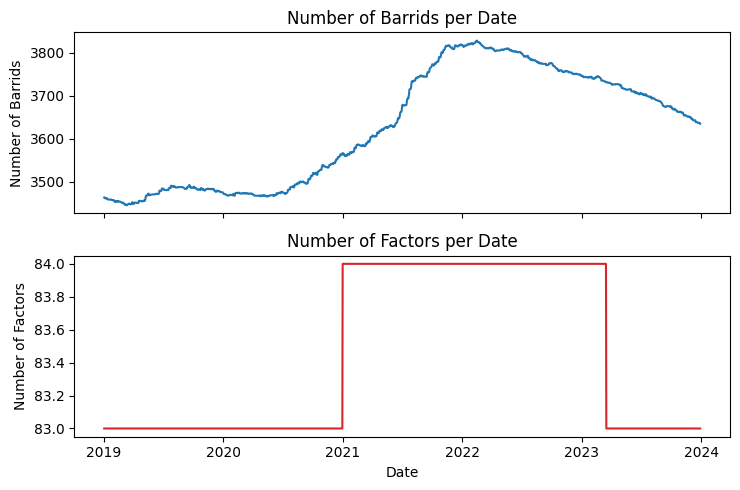

In [25]:
# (4). min and max date; the number of tickers each day
# (4.1). Time range: min and max dates:
dates_list_barra = barra_factor_exposures_df.date.unique()
print("min date, max date: ", (min(dates_list_barra), max(dates_list_barra)))

# (4.2). Calculate number of unique barrids and factors per date
# Number of barrids each date
barrids_per_date = barra_factor_exposures_df.groupby("date")["barrid"].apply(lambda x: x.unique().shape[0])
# Number of factor each date
factors_per_date = barra_factor_exposures_df.groupby("date")["factor"].apply(lambda x: x.unique().shape[0])
# Create a figure with 2 subplots (one for each metric)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 5), sharex=True)

# Plot the number of barrids on the first subplot (ax1)
ax1.plot(barrids_per_date, color='tab:blue')
ax1.set_ylabel('Number of Barrids')
ax1.set_title('Number of Barrids per Date')

# Plot the number of factors on the second subplot (ax2)
ax2.plot(factors_per_date, color='tab:red')
ax2.set_ylabel('Number of Factors')
ax2.set_xlabel('Date')
ax2.set_title('Number of Factors per Date')
plt.tight_layout()
plt.show()

In [75]:
# Find which factors cause the spike and drop:
# EFMUSATRD_CARBONEFF (style factor) is added since 2020-12-31
# EFMUSATRD_NETRET (industry factor) is removed since 2023-03-16
# We keep EFMUSATRD_NETRET and ignore EFMUSATRD_CARBONEFF in our model due to time limitation.
factor_set_each_date = barra_factor_exposures_df.groupby("date")["factor"].apply(lambda x: set(x.unique()))

factor_surge = factor_set_each_date.diff()
factor_drop = factor_set_each_date.diff(-1)
print("factor surge unique values: ", factor_surge.astype(str).unique())
print("factor drop unique values: ", factor_drop.astype(str).unique())

factor surge unique values:  ['nan' 'set()' "{'EFMUSATRD_CARBONEFF'}"]
factor drop unique values:  ['set()' "{'EFMUSATRD_NETRET'}" 'nan']


In [76]:
print("surge: ", factor_surge[factor_surge=={'EFMUSATRD_CARBONEFF'}])
print("drop: ", factor_drop[factor_drop=={'EFMUSATRD_NETRET'}])

surge:  date
2020-12-31    {EFMUSATRD_CARBONEFF}
Name: factor, dtype: object
drop:  date
2023-03-16    {EFMUSATRD_NETRET}
Name: factor, dtype: object


In [ ]:
# (5). factor types
# Split column "factor" into two parts: "EFMUSATRD_AERODEF" => "EFMUSATRD", "AERODEF"
barra_factor_exposures_df.loc[:, "factor0"] = barra_factor_exposures_df.factor.apply(lambda x: x.split("_")[0])
barra_factor_exposures_df.loc[:, "factor1"] = ba`rra_factor_exposures_df.factor.apply(lambda x: x.split("_")[1])
# Extract factor types
factor_types = barra_factor_exposures_df[["factor0", "factor1", "factor_group", "factor_name"]].\
drop_duplicates(ignore_index=True)
factor_types.to_csv("factor_types_full_data.csv", index=False)
factor_types

# # This is a synthetic example following the structure of factor-related data.
# # No proprietary data is included.

# | factor0   | factor1   | factor_group | factor_name                |
# |-----------|-----------|--------------|----------------------------|
# | xxxxxxxxx | AERODEF   | 2-Industries | US Aerospace and Defense   |
# | xxxxxxxxx | AIRLINES  | 2-Industries | US Airlines                |
# | xxxxxxxxx | ALUMSTEL  | 2-Industries | US Aluminum Steel          |
# | xxxxxxxxx | APPAREL   | 2-Industries | US Apparel and Textiles    |
# ...

In [27]:
# (6) Analyze factors:
# (6.1) factor groups are ['1-Risk Indices', '2-Industries', '5-Market']
sorted(factor_types.factor_group.unique())

['1-Risk Indices', '2-Industries', '5-Market']

In [ ]:
# (6.2) 1-Risk Indices: 3.3 Style Factors p 24
# View: According the descriptions in docs, each barrid should have a value for each factor in this group.
factor_types[factor_types["factor_group"]=='1-Risk Indices']

# # This is a synthetic example following the structure of risk indices factor data.
# # No proprietary data is included.

# | factor0   | factor1  | factor_group   | factor_name         |
# |-----------|----------|----------------|---------------------|
# | xxxxxxxxx | BETA     | 1-Risk Indices | US Beta             |
# | xxxxxxxxx | CROWD    | 1-Risk Indices | US Stock Crowding   |
# | xxxxxxxxx | DIVYILD  | 1-Risk Indices | US Dividend Yield   |
# ...

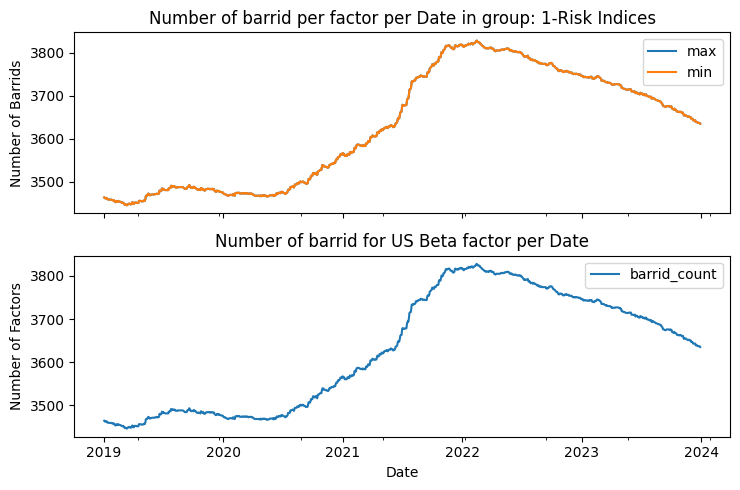

In [29]:
# Verify: Make a plot to verify my understanding is correct:
# Max and Min lines in the first plot are almost identical.
# When factor is "US Beta", the shape and value are also nearly the same.
# So, my understanding is correct.

# cast datatype from category into string
barra_factor_exposures_df["factor_name"] = barra_factor_exposures_df["factor_name"].astype("string")
barra_factor_exposures_df["factor_group"] = barra_factor_exposures_df["factor_group"].astype("string")
barra_factor_exposures_df["factor"] = barra_factor_exposures_df["factor"].astype("string")

barra_per_date_factor = barra_factor_exposures_df[barra_factor_exposures_df["factor_group"]=='1-Risk Indices'].\
groupby(["date", "factor_name"])["barrid"].count().reset_index().rename(columns={"barrid": "barrid_count"})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 5), sharex=True)
# plot 1: Max and Min Number of barrid per factor per Date in group "1-Risk Indices"
barra_per_date_factor.groupby("date")["barrid_count"].max().plot(ax=ax1, label = "max")
barra_per_date_factor.groupby("date")["barrid_count"].min().plot(ax=ax1, label = "min")
ax1.set_ylabel('Number of Barrids')
ax1.set_title('Number of barrid per factor per Date in group: 1-Risk Indices')
ax1.legend()
# plot 2: Number of barrids per Date when factor=US Beta
barra_per_date_factor[barra_per_date_factor["factor_name"]=="US Beta"].set_index("date").plot(ax=ax2, label = "US Beta")
ax2.set_ylabel('Number of Factors')
ax2.set_xlabel('Date')
ax2.set_title("Number of barrid for US Beta factor per Date")
ax2.legend()
plt.tight_layout()
plt.show()

In [30]:
# Verify by numbers: 
# on each date, all the risk factors have the same number of barrids. So, the barrid_count should be unique.
verified_df = barra_per_date_factor.groupby('date').apply(lambda group: group["barrid_count"].unique().shape[0]==1, 
                                                          include_groups=False)
verified_df.all()

True

In [ ]:
# (6.3) 2-Industries: 3.2 Industry Factors p.17
# View: According the descriptions in docs, each barrid should be classified into one industry
factor_types[factor_types["factor_group"]=='2-Industries']

# # This is a synthetic example following the structure of industry-related factor data.
# # No proprietary data is included.

# | factor0   | factor1   | factor_group | factor_name                |
# |-----------|-----------|--------------|----------------------------|
# | xxxxxxxxx | AERODEF   | 2-Industries | US Aerospace and Defense   |
# | xxxxxxxxx | AIRLINES  | 2-Industries | US Airlines                |
# | xxxxxxxxx | ALUMSTEL  | 2-Industries | US Aluminum Steel          |
# | ...

Text(0.5, 1.0, 'Number of barrid per Date in group (all factors): 2-Industries')

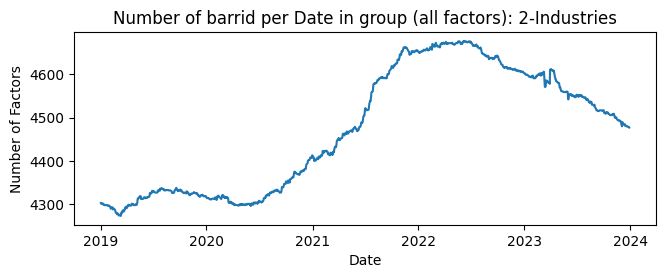

In [32]:
# Verify: Make a plot to verify my understanding is correct
# The shape is similar to the plot of 1-Risk Indices but the number of barrids on each day is higher.
barra_factor_exposures_df[barra_factor_exposures_df["factor_group"]=='2-Industries'].\
groupby(["date"])["barrid"].count().plot(figsize=(7.5, 2.5))
plt.ylabel('Number of Factors')
plt.xlabel('Date')
plt.title("Number of barrid per Date in group (all factors): 2-Industries")

In [33]:
# Verify by counting the number of industries for each barrid on each day:
# some barrids are classified into more than one industry. So, my understanding is incorret.
# Thus, each barrid is classified into at least one industry
count_df = barra_factor_exposures_df[barra_factor_exposures_df["factor_group"]=='2-Industries'].\
groupby(["date", "barrid"])["factor1"].count()
print("Any barrids are classified into more than one industry? ", (count_df>1).any())
print("examples: ", count_df[count_df>1].head())
print("how many industries are these barrids classified in? ", count_df[count_df>1].unique())

Any barrids are classified into more than one industry?  True
examples:  date        barrid 
2019-01-02  USA0C11    2
            USA16A1    2
            USA19Y1    3
            USA1B41    2
            USA1CB1    2
Name: factor1, dtype: int64
how many industries are these barrids classified in?  [2 3 5 4 6 7]


In [ ]:
# Example of stocks classified into 2 indutries:
barra_factor_exposures_df[(barra_factor_exposures_df["factor_group"]=='2-Industries')&\
(barra_factor_exposures_df["barrid"]=='USA0C11')&(barra_factor_exposures_df["date"]==datetime.date(2019, 1, 2))]

# # This is a synthetic example following the structure of factor exposure data.
# # No proprietary data is included.

# | date       | factor                   | barrid   | exposure | factor_name                | factor_group  | factor0   | factor1   |
# |------------|--------------------------|----------|----------|----------------------------|---------------|-----------|-----------|
# | 2019-01-02 | xxxxxxxxxxxxxxxxx1       | USA0001  | 0.867    | US Building Products       | 2-Industries  | xxxxxxxxx | xxxxxxx1  |
# | 2019-01-02 | xxxxxxxxxxxxxxxxx2       | USA0001  | 0.071    | US Computers Electronics   | 2-Industries  | xxxxxxxxx | xxxxxxx2  |
# |...

In [ ]:
# (6.4) 5-Market: the dataset only has one value for Market factor => US
factor_types[factor_types["factor_group"]=='5-Market']

# # This is a synthetic example following the structure of market-related factor data.
# # No proprietary data is included.

# | factor0   | factor1   | factor_group | factor_name   |
# |-----------|-----------|--------------|---------------|
# | xxxxxxxxx | xxxxxxx   | 5-Market     | US Country    |

In [36]:
# In this factor_group, all barrid has exposure=1. So, we can ignore this factor now.
barra_factor_exposures_df[barra_factor_exposures_df["factor_group"]=='5-Market'].exposure.unique()

array([1.], dtype=float32)

Text(0.5, 1.0, 'Number of barrid per Date in group (all factors): 5-Market')

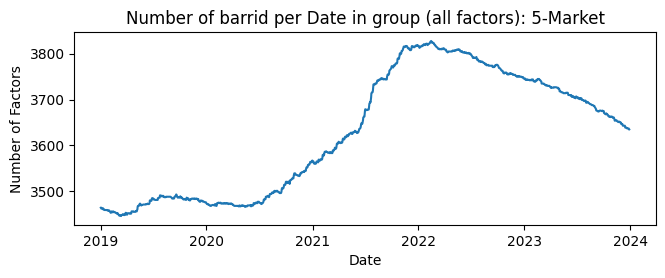

In [37]:
# Plot the number of barrids on each day in this group
barra_factor_exposures_df[barra_factor_exposures_df["factor_group"]=='5-Market'].\
groupby("date")["barrid"].count().plot(figsize=(7.5, 2.5))
plt.ylabel('Number of Factors')
plt.xlabel('Date')
plt.title("Number of barrid per Date in group (all factors): 5-Market")